<a href="https://colab.research.google.com/github/Airukua/Logistic_Regression_From_Scratch/blob/main/Logistic_Regression_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import KFold
from collections import defaultdict

In [2]:
import kagglehub
path = kagglehub.dataset_download("shuofxz/titanic-machine-learning-from-disaster")
print("Path to dataset files:", path)

100%|██████████| 33.1k/33.1k [00:00<00:00, 29.1MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/shuofxz/titanic-machine-learning-from-disaster/versions/1


In [3]:
train_file_path = os.path.join(path, "train.csv")
test_file_path = os.path.join(path, "test.csv")

In [4]:
train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

In [5]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
#copy data to analyze
check_correlation_data = train_df.copy()
check_correlation_data['Sex'] = check_correlation_data['Sex'].map({'male': 1, 'female': 0})
check_correlation_data = pd.get_dummies(check_correlation_data, columns=['Embarked', 'Pclass'], drop_first=True)

In [9]:
columns_to_drop = ['Name', 'Ticket', 'Cabin', 'PassengerId']
check_correlation_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [10]:
check_correlation_data.fillna(0, inplace=True)


Correlation Heatmap (including categorical data):


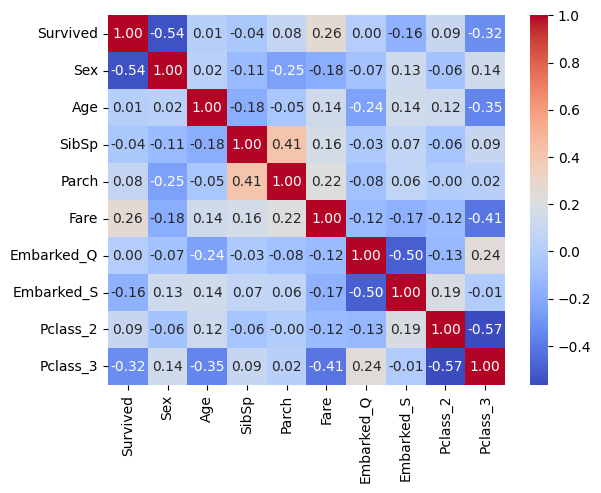

In [11]:
print("\nCorrelation Heatmap (including categorical data):")
sns.heatmap(check_correlation_data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

In [12]:
# Fill missing 'Age' using median grouped by 'Pclass' and 'Sex'
train_df['Age'] = train_df.groupby(['Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(x.median()))

# Fill missing 'Embarked' with mode
train_df['Embarked'] = train_df['Embarked'].fillna(train_df['Embarked'].mode()[0])

# Fill missing 'Fare' in test train_df with median
train_df['Fare'] = train_df['Fare'].fillna(train_df['Fare'].median())

# Drop 'Cabin' due to many missing values
train_df.drop(columns=['Cabin'], inplace=True)

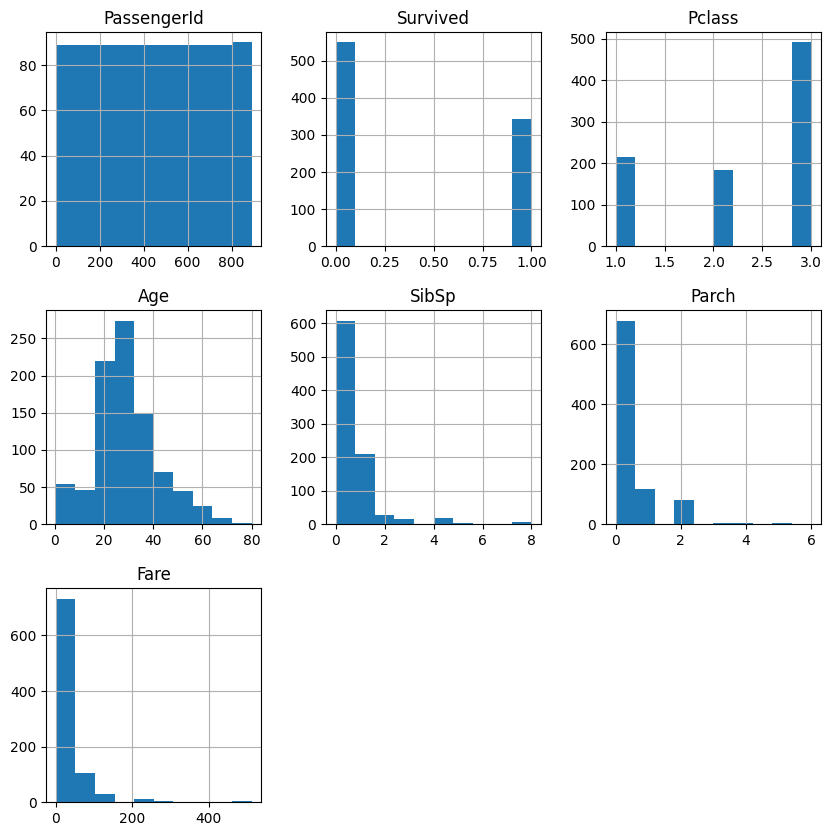

In [13]:
train_df.hist(figsize=(10, 10))
plt.show()

In [14]:
scaler= StandardScaler()
train_df[['Age', 'Fare']] = scaler.fit_transform(train_df[['Age', 'Fare']])

In [37]:
class LogisticRegression:
    def __init__(self, X):
        self.X = X
        m, n = X.shape
        self.weight = np.zeros((n, 1))
        self.bias = 0

    def sigmoid(self, z):
        # Handle numerical stability
        return 1 / (1 + np.exp(-np.clip(z, -500, 500)))

    def predict(self, X):
        return self.sigmoid(np.dot(X, self.weight) + self.bias)

    def fit(self, learning_rate, epoch, learning_tolerance, Y):
        running_loss = 0.0
        prev_loss = float('inf')

        for _ in range(epoch):
            y_pred = self.predict(self.X)

            # Calculate loss
            loss = -np.mean(Y * np.log(y_pred + 1e-15) + (1 - Y) * np.log(1 - y_pred + 1e-15))

            # Calculate gradients
            dw = (1 / len(self.X)) * np.dot(self.X.T, (y_pred - Y))
            db = (1 / len(self.X)) * np.sum(y_pred - Y)

            # Update weights and bias
            self.weight -= learning_rate * dw
            self.bias -= learning_rate * db

            # Early stopping if loss change is small
            if abs(prev_loss - loss) < learning_tolerance:
                break
            prev_loss = loss

            running_loss += loss

        return running_loss / epoch

    def prediction_label(self, y_pred):
        return np.where(y_pred > 0.5, 1, 0)

    def evaluation_matrix(self, y_pred, Y):
        y_pred = self.prediction_label(y_pred)

        TP = np.sum((y_pred == 1) & (Y == 1))
        FP = np.sum((y_pred == 1) & (Y == 0))
        FN = np.sum((y_pred == 0) & (Y == 1))
        TN = np.sum((y_pred == 0) & (Y == 0))

        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = (TP + TN) / (TP + TN + FP + FN)

        return {
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1_score,
            "Accuracy": accuracy
        }

In [16]:
# Convert 'Sex' to numerical values
train_df['Sex'] = LabelEncoder().fit_transform(train_df['Sex'])

# Extract Title from 'Name'
train_df['Title'] = train_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
train_df['Title'] = train_df['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev',
                                        'Sir', 'Jonkheer', 'Dona'], 'Rare')
train_df['Title'] = train_df['Title'].replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'})

# Drop 'Name' and 'Ticket' as they are not useful for predictions
train_df.drop(columns=['Name', 'Ticket'], inplace=True)

# One-hot encode 'Embarked' and 'Title'
train_df = pd.get_dummies(train_df, columns=['Embarked', 'Title'], drop_first=True)

In [17]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    int64  
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Embarked_Q   891 non-null    bool   
 9   Embarked_S   891 non-null    bool   
 10  Title_Miss   891 non-null    bool   
 11  Title_Mr     891 non-null    bool   
 12  Title_Mrs    891 non-null    bool   
 13  Title_Rare   891 non-null    bool   
dtypes: bool(6), float64(2), int64(6)
memory usage: 61.0 KB


In [18]:
X = train_df.drop(columns=['Survived', 'PassengerId'])
y = train_df['Survived']

In [19]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,3,1,-0.534891,1,0,-0.502445,False,True,False,True,False,False
1,1,0,0.668392,1,0,0.786845,False,False,False,False,True,False
2,3,0,-0.234070,0,0,-0.488854,False,True,True,False,False,False
3,1,0,0.442776,1,0,0.420730,False,True,False,False,True,False
4,3,1,0.442776,0,0,-0.486337,False,True,False,True,False,False


In [20]:
#Hyperparamter
learning_rate = np.arange(0.01, 1.0, 0.01)
learning_tolerance = 0.0001
epochs = np.arange(100,1100,100)
KFold = KFold(n_splits=5, shuffle=True, random_state=42)

In [21]:
X = X.values.astype(float)
y = y.values

In [22]:
metrics_summary = defaultdict(list)

for fold, (train_index, test_index) in enumerate(KFold.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print(f"Fold {fold + 1}")

    for lr in learning_rate:
        for epoch in epochs:
            model = LogisticRegression(X_train)
            loss  = model.fit(lr, epoch, learning_tolerance, y_train.reshape(-1, 1))


            y_pred = model.predict(X_test)

            evaluation_metrics = model.evaluation_matrix(y_pred, y_test.reshape(-1, 1))
            metrics_summary[(lr, epoch)].append(evaluation_metrics)
            print(f"Learning rate: {lr}, Epochs: {epoch}")
            print(f"Metrics: {evaluation_metrics}")
            print('-' * 40)


Streaming output truncated to the last 5000 lines.
----------------------------------------
Learning rate: 0.32, Epochs: 500
Metrics: {'Precision': 0.7368421052631579, 'Recall': 0.6363636363636364, 'F1-Score': 0.6829268292682926, 'Accuracy': 0.7808988764044944}
----------------------------------------
Learning rate: 0.32, Epochs: 600
Metrics: {'Precision': 0.7413793103448276, 'Recall': 0.6515151515151515, 'F1-Score': 0.6935483870967741, 'Accuracy': 0.7865168539325843}
----------------------------------------
Learning rate: 0.32, Epochs: 700
Metrics: {'Precision': 0.7413793103448276, 'Recall': 0.6515151515151515, 'F1-Score': 0.6935483870967741, 'Accuracy': 0.7865168539325843}
----------------------------------------
Learning rate: 0.32, Epochs: 800
Metrics: {'Precision': 0.7543859649122807, 'Recall': 0.6515151515151515, 'F1-Score': 0.6991869918699187, 'Accuracy': 0.7921348314606742}
----------------------------------------
Learning rate: 0.32, Epochs: 900
Metrics: {'Precision': 0.754385

In [28]:
average_metrics = {}
for key, values in metrics_summary.items():
    metric_averages = {}
    for metric in values[0]:
        metric_values = [v[metric] for v in values]
        metric_averages[metric] = np.mean(metric_values)
    average_metrics[key] = metric_averages
    print(f"Learning rate: {key[0]}, Epochs: {key[1]}, Average Metrics: {metric_averages}")

Learning rate: 0.01, Epochs: 100, Average Metrics: {'Precision': 0.9016666666666666, 'Recall': 0.0793478459150101, 'F1-Score': 0.145105531021024, 'Accuracy': 0.6431360241039483}
Learning rate: 0.01, Epochs: 200, Average Metrics: {'Precision': 0.8864433811802233, 'Recall': 0.18260974738586677, 'F1-Score': 0.3013939368995549, 'Accuracy': 0.6790157554453581}
Learning rate: 0.01, Epochs: 300, Average Metrics: {'Precision': 0.9097593582887701, 'Recall': 0.2500643446912104, 'F1-Score': 0.3916578783503002, 'Accuracy': 0.7037097482894985}
Learning rate: 0.01, Epochs: 400, Average Metrics: {'Precision': 0.874554017894979, 'Recall': 0.2992169454856022, 'F1-Score': 0.44470626054521284, 'Accuracy': 0.7160441905718412}
Learning rate: 0.01, Epochs: 500, Average Metrics: {'Precision': 0.8650909842845327, 'Recall': 0.3581892143086173, 'F1-Score': 0.5060000206772606, 'Accuracy': 0.7328792919465194}
Learning rate: 0.01, Epochs: 600, Average Metrics: {'Precision': 0.8440445053348279, 'Recall': 0.41657662

In [30]:
best_f1_score = -1
best_params = None

for key, metrics in average_metrics.items():
    learning_rate, epochs = key

    if learning_rate < 0.5 and metrics["F1-Score"] > best_f1_score:
        best_f1_score = metrics["F1-Score"]
        best_params = key

if best_params:
    print(f"Best F1 Score: {best_f1_score}")
    print(f"Achieved with Learning Rate: {best_params[0]}, Epochs: {best_params[1]}")
else:
    print("No valid configurations found with learning rate < 0.5")


Best F1 Score: 0.7553831713414174
Achieved with Learning Rate: 0.4, Epochs: 1000


In [33]:
model = LogisticRegression(X)
loss  = model.fit(learning_rate=0.4, epoch=1000, learning_tolerance=1e-5, Y=y.reshape(-1, 1))

In [35]:
y_pred = model.predict(X)
metrics = model.evaluation_matrix(y_pred, y)

print(f"Loss: {loss}")
print(metrics)

Loss: 0.42834065085725354
{'Precision': 0.3838383838383838, 'Recall': 0.35353535353535354, 'F1-Score': 0.368064203680642, 'Accuracy': 0.5340271400877461}
